<a href="https://colab.research.google.com/github/Adityeah18/tensorflow/blob/main/fuel_efficiency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fuel Efficiency Prediction

In a regression problem, the aim is to predict the output of a continuous value, like a price or a probability. Contrast this with a classification problem, where the aim is to select a class from a list of classes (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

This tutorial uses the classic Auto MPG dataset and demonstrates how to build models to predict the fuel efficiency of the late-1970s and early 1980s automobiles. To do this, you will provide the models with a description of many automobiles from that time period. This description includes attributes like cylinders, displacement, horsepower, and weight.

In [ ]:
!pip install tensorflow

!pip install -q seaborn



In [49]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

#To make the numpy print easier to read
np.set_printoptions(precision=1,suppress=True)
print(tf.__version__)

2.18.0


##Dataset

###Downloading the Data

In [50]:
import pandas as pd

url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(
    url,
    names=column_names,
    na_values='?',        # correct: not `na_vlaues`
    comment='\t',
    sep='\s+',            # correct separator for whitespace
    skipinitialspace=True
)

dataset = raw_dataset.copy()  # making copy of raw dataset is best practice as there will no change in raw and backtracking for debug is easy
#dataset.head()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
27.0,4,140.0,86.0,2790.0,15.6,82,1,ford mustang gl
44.0,4,97.0,52.0,2130.0,24.6,82,2,vw pickup
32.0,4,135.0,84.0,2295.0,11.6,82,1,dodge rampage
28.0,4,120.0,79.0,2625.0,18.6,82,1,ford ranger
31.0,4,119.0,82.0,2720.0,19.4,82,1,chevy s-10


###Cleaning data

In [51]:
#data set hav the few unknwn values
dataset.isna().sum()
#Now droppinng those unkown
dataset=dataset.dropna()


In [52]:
#As seen the Origin column is categorical columns, we have one hot encode it
dataset['Origin']=dataset['Origin'].map({1:'USA',2:'Europe',3:'Japan'}) #tells as dicctionary 1 for USA 2 Europe and 3 for Japan

#One-hot Encoded
dataset=pd.get_dummies(dataset,columns=['Origin'],prefix="",prefix_sep='')
dataset.tail()


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year
27.0,4,140.0,86.0,2790.0,15.6,82,1
44.0,4,97.0,52.0,2130.0,24.6,82,2
32.0,4,135.0,84.0,2295.0,11.6,82,1
28.0,4,120.0,79.0,2625.0,18.6,82,1
31.0,4,119.0,82.0,2720.0,19.4,82,1


##Splitting Data in Test/Train

In [53]:
train_dataset=dataset.sample(frac=0.8, random_state=0) #MAking 80 % in train set and random select each time the same datapoints for everytime it executes
test_dataset=dataset.drop(train_dataset.index) #The remaining datapoints 20% will be in out testset
#Usually sklearn does the test_train_spli part but manuallu doing is also not bad

###Inspecting the datset

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Cylinders,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Displacement,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Horsepower,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Weight,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Acceleration,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Model Year,314.0,1.573248,0.800988,1.0,1.00,1.0,2.00,3.0


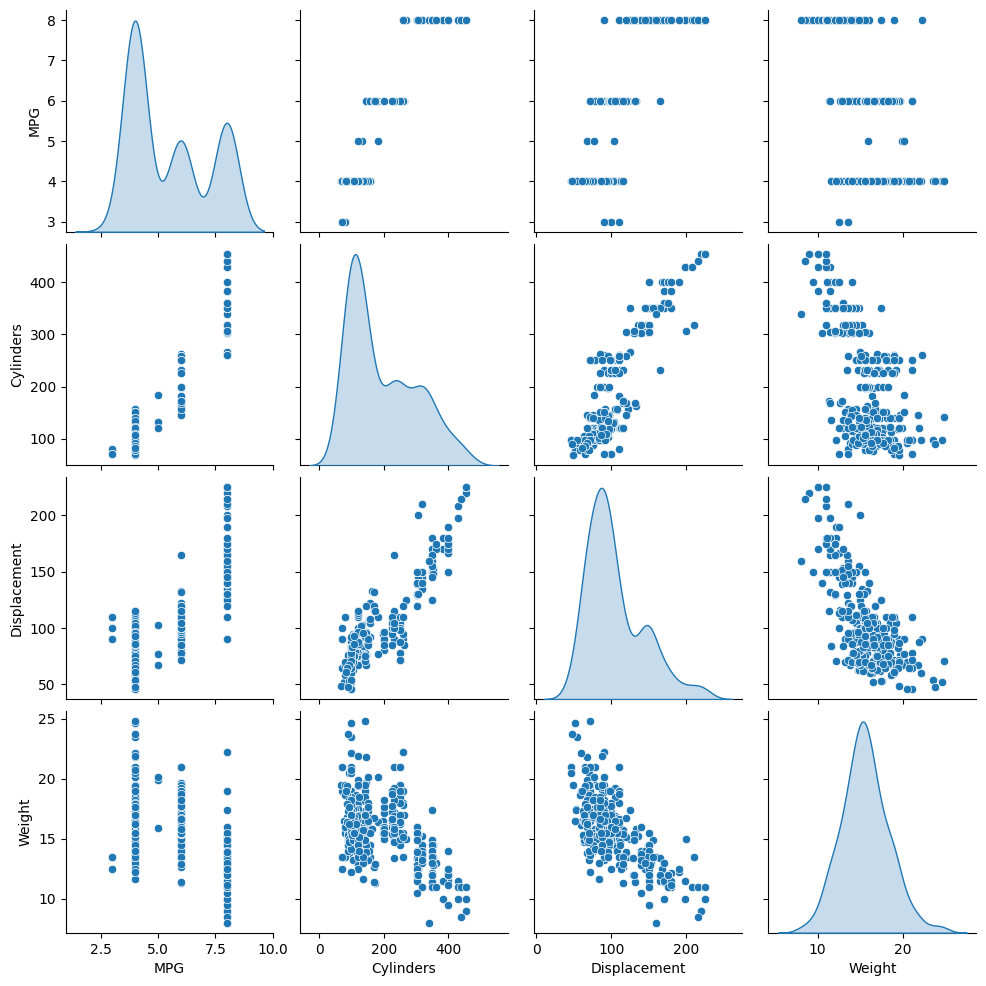

In [54]:
#Correlation with PG efficiency is the function all other parameters
sns.pairplot(train_dataset[['MPG','Cylinders','Displacement','Weight']],diag_kind='kde')
train_dataset.describe().transpose()

###Matplotlib

In [55]:

def plot_loss(history):
  plt.plot(history.history['loss'],label='loss')
  plt.plot(history.history['val_loss'],label='val_loss')
  plt.ylim([0,10])
  plt.xlabel('Epoch')
  plt.ylabel('Error[MPG]')
  plt.legend()
  plt.grid(True)


###Splitting the featurees from the target

In [56]:
#Feature
train_feature=train_dataset.copy() #X_train
test_feature=test_dataset.copy() #Xtest
#Targets
train_label=train_feature.pop('MPG') #y_train,List of only mpg labels
test_label=test_feature.pop('MPG')#y_test list of only mpg labels


###Normalization

In [57]:
#Normalization
#Its like Standard Scaler kinda preprocessing
from tensorflow.keras import layers

#Normalizer Layer
normalizer=tf.keras.layers.Normalization(axis=-1)

#Fitting features
normalizer.adapt(np.array(train_feature))

#calculate the mean and variance and storing them in the layer
print(normalizer.mean.numpy())

first=np.array(train_feature.iloc[:1].values)

with np.printoptions(precision=2,suppress=True):
  print(f'First Example {first}')
  print()
  print("Normalized:",normalizer(first).numpy())

[[ 195.3  104.9 2990.3   15.6   75.9    1.6]]
First Example [[  90.    75.  2125.    14.5   74.     1. ]]

Normalized: [[-1.01 -0.79 -1.03 -0.38 -0.52 -0.72]]


## Linear Regression

* DNN= deep neural network


* input in normalization layer

*   Let this be 2 hidden layers for non linear
*  A single layer linear output







###Model

In [58]:
from tensorflow.keras import Layer
model=tf.keras.Sequential([normalizer,
                        layers.Dense(64,activation='relu'),
                        layers.Dense(64,activation='relu'),
                        layers.Dense(1)])

###Compile

In [59]:
#Compile
model.compile(optimizer='adam',
              loss='mean_absolute_error'
              )

###Fit

Epoch 1/10
8/8 - 3s - 435ms/step - loss: 5.4008 - val_loss: 4.9555
Epoch 2/10
8/8 - 1s - 117ms/step - loss: 4.8681 - val_loss: 4.3674
Epoch 3/10
8/8 - 0s - 39ms/step - loss: 4.3061 - val_loss: 3.7262
Epoch 4/10
8/8 - 0s - 20ms/step - loss: 3.6694 - val_loss: 2.9592
Epoch 5/10
8/8 - 0s - 30ms/step - loss: 2.8714 - val_loss: 2.0682
Epoch 6/10
8/8 - 0s - 39ms/step - loss: 2.0378 - val_loss: 1.5572
Epoch 7/10
8/8 - 0s - 39ms/step - loss: 1.5748 - val_loss: 1.6982
Epoch 8/10
8/8 - 0s - 36ms/step - loss: 1.4866 - val_loss: 1.6837
Epoch 9/10
8/8 - 0s - 35ms/step - loss: 1.3746 - val_loss: 1.5149
Epoch 10/10
8/8 - 0s - 38ms/step - loss: 1.2642 - val_loss: 1.3777


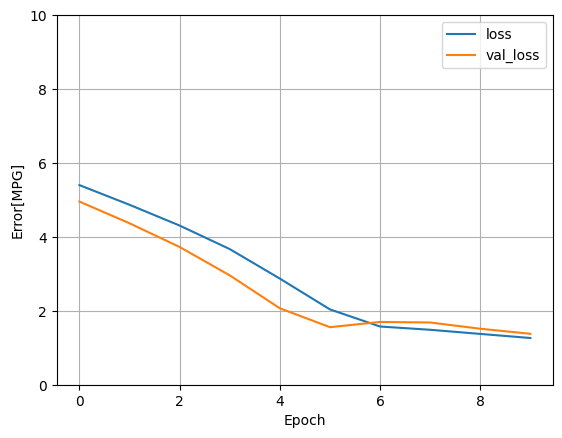

In [60]:
#Model fit
history = model.fit(train_feature,train_label,
                    validation_split=0.2,
                    verbose=2,
                    epochs=10)
plot_loss(history)

###Evaluate

In [61]:

result=model.evaluate(test_feature,test_label,verbose=2)

1/1 - 0s - 253ms/step - loss: 1.0669


For better repesentattion , used pandas dataframe

In [67]:
pd.DataFrame([result],index=['Mean abs error[ MPG]'])

,0
Mean abs error[ MPG],1.066894


###Prediction

In [63]:
prediction=model.predict(test_feature).flatten() #.flatten() converts the 2D output to a 1D list.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


matplotlib

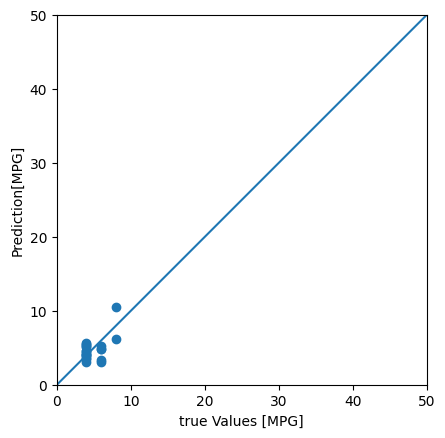

In [64]:
#Matplotlib for prediction
a=plt.axes(aspect='equal')
plt.scatter(test_label,prediction)
plt.xlabel('true Values [MPG]')
plt.ylabel("Prediction[MPG]")
lims=[0,50]
plt.xlim(lims)
plt.ylim(lims)
_=plt.plot(lims,lims)

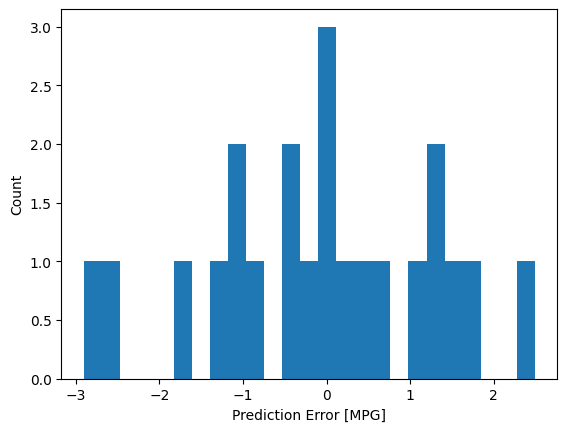

In [65]:
error=prediction-test_label
plt.hist(error,bins=25)
plt.xlabel("Prediction Error [MPG]")
_=plt.ylabel('Count')


###Saving model

In [66]:
#Saving the model
model.save('fuel_dnn.h5')